# Portafolios de Inversión
## Proyecto Final

Presenta :

- Juan Ramón López Rocha

- José Armando Melchor Soto

- Paula Ines Pelayo Morales
---



### Librerías


In [1057]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

warnings.filterwarnings('ignore')


---

### Funciones

#### Función Analisis de Acciones

In [1058]:
def analizar_brkb():
    ticker_f = "BRK-B"
    accion = yf.Ticker(ticker_f)

    # Obtener datos generales
    info = accion.info
    current_price = info.get('regularMarketPrice', info.get('currentPrice', None))
    book_value_per_share = info.get('bookValue', None)
    trailing_eps = info.get('trailingEps', None)

    if None in (current_price, book_value_per_share, trailing_eps):
        return f"Error: No se pudo obtener alguno de los datos básicos para {ticker_f}."

    price_to_earnings = current_price / trailing_eps

    evaluacion_pe = f"P/E: {price_to_earnings:.2f}. Compara con el S&P 500 (~15–20) para contexto."

    try:
        income_statement = accion.financials
        balance_sheet = accion.balance_sheet

        net_income = income_statement.loc['Net Income Common Stockholders'].iloc[0]
        total_assets = balance_sheet.loc['Total Assets'].iloc[0]
        total_equity = balance_sheet.loc["Total Equity Gross Minority Interest"].iloc[0]

        roa = net_income / total_assets if total_assets else None
        roe = net_income / total_equity if total_equity else None

        roa_str = f"{roa:.2%}" if roa is not None else "N/D"
        roe_str = f"{roe:.2%}" if roe is not None else "N/D"

    except Exception as e:
        roa_str = roe_str = "Error al obtener datos financieros"
        print("Error:", e)

    return (
        f"\nAnálisis de {ticker_f}\n"
        f"Precio Actual: ${current_price:.2f}\n"
        f"EPS (Trailing): ${trailing_eps:.2f}\n"
        f"Price-to-Earnings (P/E): {price_to_earnings:.2f}\n"
        f"ROA: {roa_str}\n"
        f"ROE: {roe_str}\n\n"
    )


In [1059]:
def analizar_accion(ticker_f):
    accion = yf.Ticker(ticker_f)
    # Obtener datos
    info = accion.info
    current_price = info.get('regularMarketPrice', info.get('currentPrice', None))
    book_value_per_share = info.get('bookValue', None)
    trailing_eps = info.get('trailingEps', None)

    # Validar datos
    if None in (current_price, book_value_per_share, trailing_eps):
        return f"Error: No se pudo obtener alguno de los datos para {ticker_f}."

    # Cálculos
    price_to_book = current_price / book_value_per_share if book_value_per_share else None
    price_to_earnings = current_price / trailing_eps if trailing_eps else None

    # Evaluación P/B
    if price_to_book <= 1.2:
        evaluacion_pb = "P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett)."
    elif price_to_book <= 1.6:
        evaluacion_pb = "P/B entre 1.2–1.6: Valuación razonable (rango histórico)."
    else:
        evaluacion_pb = "P/B > 1.6: Posible sobrevaloración."

    # Evaluación P/E
    evaluacion_pe = f"P/E: {price_to_earnings:.2f}. Compara con el S&P 500 (~15–20) para contexto."

    # Resultados
    return (
        f"\nMétricas de {ticker_f}:\n"
        f"Precio Actual: ${current_price:.2f}\n"
        f"EPS (Trailing): ${trailing_eps:.2f}\n"
        f"Price-to-Book (P/B): {price_to_book:.2f}\n"
        f"Price-to-Earnings (P/E): {price_to_earnings:.2f}\n\n"
        f"Evaluación:\n{evaluacion_pb}\n{evaluacion_pe}"
    )


#### Clase Optimizar Pesos

In [1060]:
class OptimizePortfolioWeights:

    def __init__(self, returns: pd.DataFrame, risk_free: float):

        self.rets = returns
        self.cov = returns.cov()
        self.rf = risk_free / 252
        self.n_stocks = len(returns.columns)

    # Min Variance
    def opt_min_var(self):


        var = lambda w: w.T @ self.cov @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 1)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=var, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'},
                        tol=1e-16)

        return result.x

    # Sharpe Ratio
    def opt_max_sharpe(self):
        rets = self.rets
        rend, cov, rf = self.rets.mean(), self.cov, self.rf

        sr = lambda w: -((np.dot(rend, w) - rf) / ((w.reshape(-1, 1).T @ cov @ w) ** 0.5))

        result = minimize(sr, np.ones(len(rets.T)), bounds=[(0, None)] * len(rets.T),
                          constraints={'fun': lambda w: sum(w) - 1, 'type': 'eq'},
                          tol=1e-16)

        return result.x

    # Semivariance method
    def opt_min_semivar(self, rets_benchmark):

        rets, corr=self.rets.copy(), self.rets.corr()

        diffs=rets-rets_benchmark.values

        below_zero_target=diffs[diffs<0].fillna(0)
        target_downside=np.array(below_zero_target.std())

        target_semivariance=np.multiply(target_downside.reshape(len(target_downside), 1), target_downside) * corr

        semivar = lambda w: w.T @ target_semivariance @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 3)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=semivar, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return result.x

    # Omega
    def opt_max_omega(self, rets_benchmark):

        rets=self.rets.copy()

        diffs=rets-rets_benchmark.values

        below_zero_target=diffs[diffs<0].fillna(0)
        above_zero_target=diffs[diffs>0].fillna(0)

        target_downside=np.array(below_zero_target.std())
        target_upside=np.array(above_zero_target.std())
        o=target_upside/target_downside

        omega = lambda w: -sum(o * w)


        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0,3)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=omega, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return result.x


#### Clase Dynamic Backtesting

In [1061]:
capital = 1000000

In [1062]:
class dynamic_backtesting:

    def __init__(self, prices_tactical, prices_strategic, prices_benchmark, capital, rf, months):
        self.prices_tactical = prices_tactical
        self.prices_strategic = prices_strategic
        self.prices_benchmark = prices_benchmark
        self.capital = capital
        self.rf = rf
        self.months = months

    def optimize_weights(self, prices: pd.DataFrame, n_days: int, periods: int):
        start = int(n_days * periods)
        end = int(n_days * (periods + 1))

        temp_data = prices.iloc[start:end, :]
        temp_bench = self.prices_benchmark.iloc[start:end, :]

        temp_rets = temp_data.pct_change().dropna()
        rets_benchmark = temp_bench.pct_change().dropna()

        optimizer = OptimizePortfolioWeights(returns=temp_rets, risk_free=self.rf)

        w_minvar = pd.Series(optimizer.opt_min_var(), index=prices.columns)
        w_sharpe = pd.Series(optimizer.opt_max_sharpe(), index=prices.columns)
        w_semivar = pd.Series(optimizer.opt_min_semivar(rets_benchmark), index=prices.columns)
        w_omega = pd.Series(optimizer.opt_max_omega(rets_benchmark), index=prices.columns)

        return w_minvar, w_sharpe, w_semivar, w_omega

    def simulation(self):
        total_days = len(self.prices_tactical)
        n_periods = round(total_days / 252 * (12 / self.months))
        n_days = round(total_days / n_periods)

        capital = self.capital

        opt_data = self.prices_tactical.iloc[:n_days, :]
        backtesting_tactical = self.prices_tactical.iloc[n_days:, :]
        backtesting_strategic = self.prices_strategic.iloc[n_days:, :]
        backtesting_benchmark = self.prices_benchmark.iloc[n_days:, :]

        rets_tactical = backtesting_tactical.pct_change().dropna()
        rets_strategic = backtesting_strategic.pct_change().dropna()
        rets_benchmark = backtesting_benchmark.pct_change().dropna()

        min_len = min(len(rets_tactical), len(rets_strategic), len(rets_benchmark))
        rets_tactical = rets_tactical.iloc[:min_len, :]
        rets_strategic = rets_strategic.iloc[:min_len, :]
        rets_benchmark = rets_benchmark.iloc[:min_len, :]

        minvar, sharpe, semivar, omega = [capital], [capital], [capital], [capital]
        day_counter, periods_counter = 0, 0

        w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(opt_data, n_days, 0)

        # Pesos estratégicos fijos uniformes
        w_strategic = pd.Series(
            [1 / self.prices_strategic.shape[1]] * self.prices_strategic.shape[1],
            index=self.prices_strategic.columns
        )

        for day in range(min_len - 1):
            if day_counter == n_days:
                w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(backtesting_tactical, n_days, periods_counter)
                periods_counter += 1
                day_counter = 0

            combined_minvar = w_minvar.add(w_strategic, fill_value=0)
            combined_sharpe = w_sharpe.add(w_strategic, fill_value=0)
            combined_semivar = w_semivar.add(w_strategic, fill_value=0)
            combined_omega = w_omega.add(w_strategic, fill_value=0)

            combined_minvar /= combined_minvar.sum()
            combined_sharpe /= combined_sharpe.sum()
            combined_semivar /= combined_semivar.sum()
            combined_omega /= combined_omega.sum()

            rets_combined = pd.concat([
                rets_tactical.iloc[day, :],
                rets_strategic.iloc[day, :]
            ])

            minvar.append(minvar[-1] * (1 + (rets_combined @ combined_minvar)))
            sharpe.append(sharpe[-1] * (1 + (rets_combined @ combined_sharpe)))
            semivar.append(semivar[-1] * (1 + (rets_combined @ combined_semivar)))
            omega.append(omega[-1] * (1 + (rets_combined @ combined_omega)))

            day_counter += 1

        # Capital acumulado benchmark
        capital_benchmark = capital * (1 + rets_benchmark.sum(axis=1)).cumprod()
        capital_benchmark = capital_benchmark.iloc[:len(minvar)-1]  # igual largo

        df = pd.DataFrame({
            'Date': backtesting_tactical.index[:len(minvar)-1],
            'Mínima Varianza': minvar[:-1],
            'Máximo Sharpe': sharpe[:-1],
            'Semi Varianza': semivar[:-1],
            'Máximo Omega': omega[:-1],
            'Benchmark': capital_benchmark.values
        }).set_index('Date')

        return df




#### Función Métricas de Desempeño

In [1063]:
def metricas_anuales(history, rf):
    # Returns
    rets= history.pct_change().dropna()
    
    # Matriz de Cov
    cov_hist = rets.cov()

    # Dataframe
    metricas = pd.DataFrame(index=rets.columns)

    # Rendimiento 
    metricas['Rendimiento Promedio Anual'] = R_p = rets.mean()*252
    
    # Volatilidad 
    metricas['Volatilidad Anual'] = vol_anual = rets.std()*np.sqrt(252)
    
    # Ratio de Sharpe
    metricas['Ratio de Sharpe'] = (R_p - rf) / vol_anual

    # Downside Risk
    metricas['Downside Risk'] = downside = rets[rets < 0].fillna(0).std() * np.sqrt(252) 

    # Upside Risk
    metricas['Upside Risk'] = upside = rets[rets > 0].fillna(0).std() * np.sqrt(252) 

    # Omega
    metricas['Omega'] =omega= upside / downside

    # Beta

    covs = cov_hist['Benchmark']
    varianza_market = covs['Benchmark']
    metricas['Beta'] = beta = covs / varianza_market

    # Alfa de Jensen

    R_m = rets['Benchmark'].mean() * 252 
    metricas['Alpha']=alpha_Jensen = R_p - (rf + beta * (R_m - rf))

    # Ratio de Treynor
    metricas['Ratio de Treynor'] = (R_p - rf) / beta

    # Ratio de Sortino
    metricas['Ratio de Sortino'] = (R_p - rf) / downside

    return metricas.T

#### Función Gráfica

In [ ]:
def plot_weights_pie(df_percent, strategy_name):
    if strategy_name not in df_percent.columns:
        print(f"'{strategy_name}' no está en las columnas del DataFrame.")
        return

    weights = df_percent[strategy_name]

    # Normalizar a proporción si están en porcentaje (>1.5)
    if weights.max() > 1.5:
        weights = weights / 100

    palette = sns.color_palette('Greys', len(weights))

    labels_for_pie = [
        f"{name} ({weight * 100:.2f}%)" if weight > 0.0001 else ''
        for name, weight in zip(weights.index, weights)
    ]

    legend_labels = [f"{name} ({weight * 100:.2f}%)" for name, weight in zip(weights.index, weights)]

    handles = [mpatches.Circle((0, 0), radius=5, facecolor=color) for color in palette]

    plt.figure(figsize=(10, 6))
    plt.title(f"Estrategia: {strategy_name}", fontsize=16, fontweight='bold')
    plt.pie(
        weights,
        labels=labels_for_pie,
        colors=palette,
        labeldistance=1.05,
        startangle=90
    )
    plt.axis('equal')

    # Leyenda en posición default con círculos y etiquetas completas
    plt.legend(
        handles,
        legend_labels,
        title='Activos',
        fontsize=10,
        handletextpad=0.6,
        labelspacing=0.5,
        borderpad=0.8,
        frameon=False
    )

    plt.tight_layout()
    plt.show()

### EJEMPLO
## plot_weights_pie(combined_df_percentage, 'Mínima Varianza')
#plot_weights_pie(combined_df_percentage, 'Máximo Sharpe')


---

### Obtención de Datos

In [1065]:
tickers = yf.download(['BRK-B', 'AZO', 'META','NEM','ED','WMT'], start='2024-01-01', end='2025-07-01' ,progress=False,)['Close']
benchmark = yf.download('^GSPC', start='2024-01-01', end='2025-07-01',progress=False)['Close']


In [1066]:
ret = tickers.pct_change().dropna()
rets_benchmark = benchmark.pct_change().dropna()

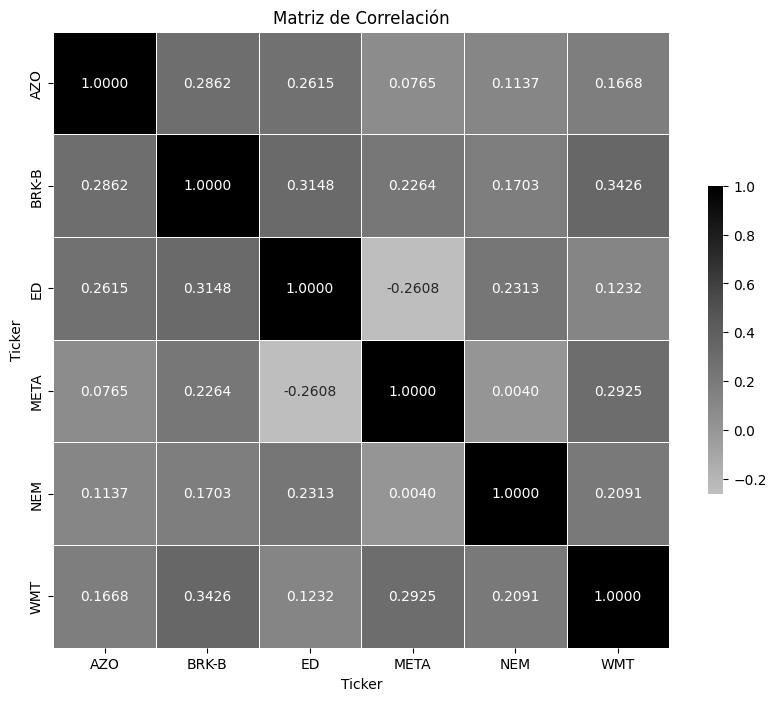

In [1067]:
corr = ret.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".4f", cmap='Greys', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Matriz de Correlación')
plt.show()

In [1068]:
tickers_valuation = ['AZO', 'META','NEM','ED','WMT']
def get_financials(ticker:str) -> pd.DataFrame:
    bs = yf.Ticker(ticker).balance_sheet.iloc[:, :-1]
    ist = yf.Ticker(ticker).income_stmt.iloc[:, :-1]
    cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]

    return bs, ist, cf

Múltiplos de AZO


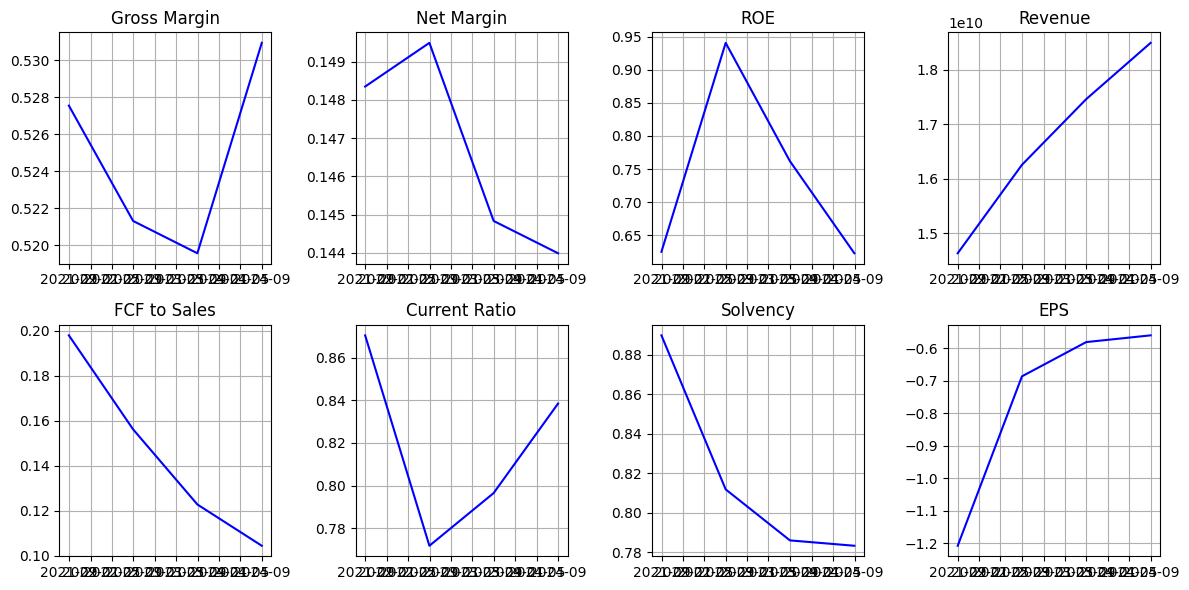

Múltiplos de META


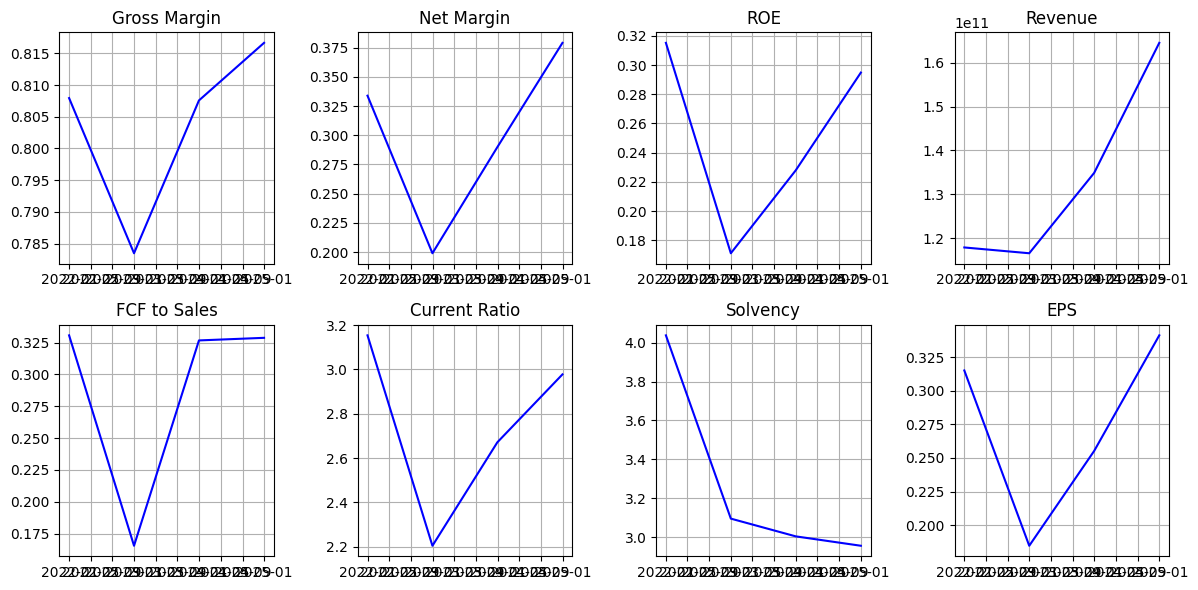

Múltiplos de NEM


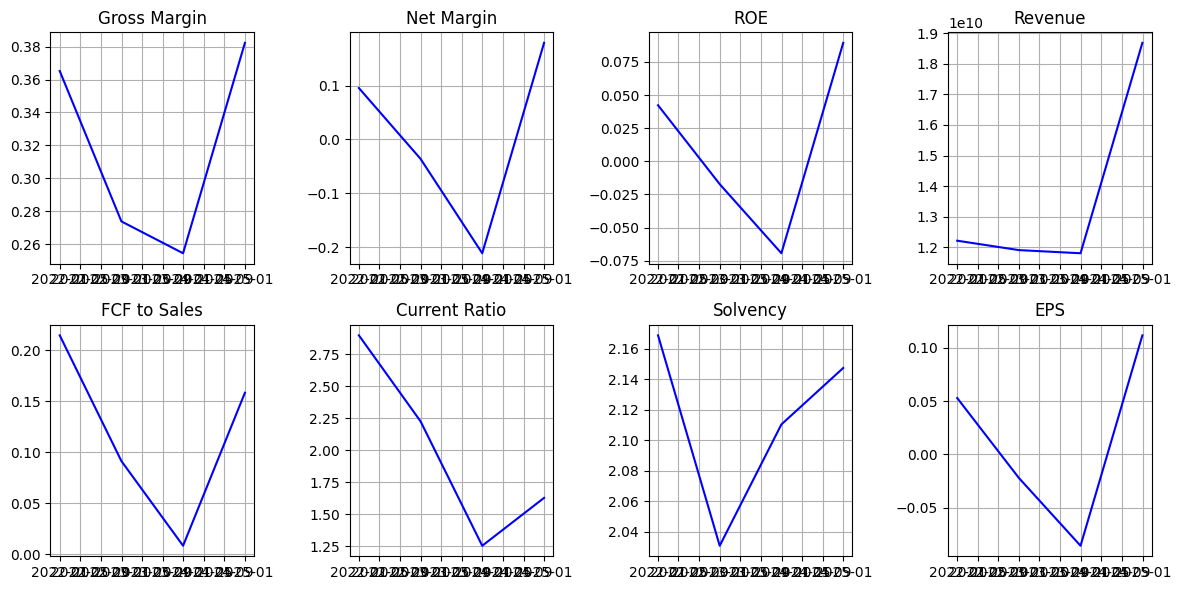

Múltiplos de ED


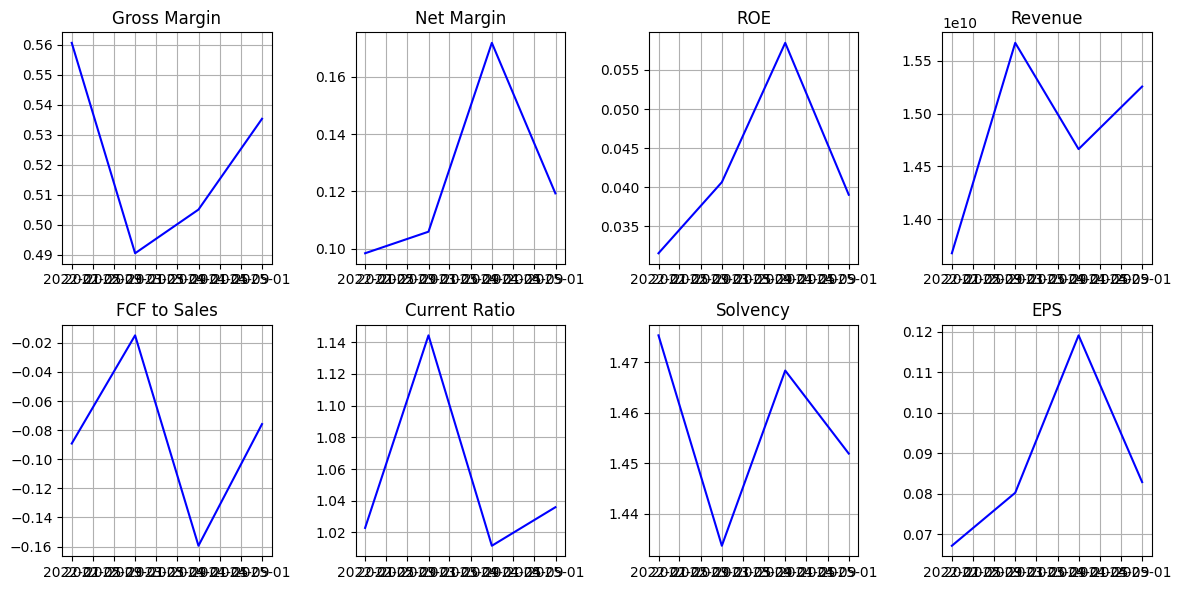

Múltiplos de WMT


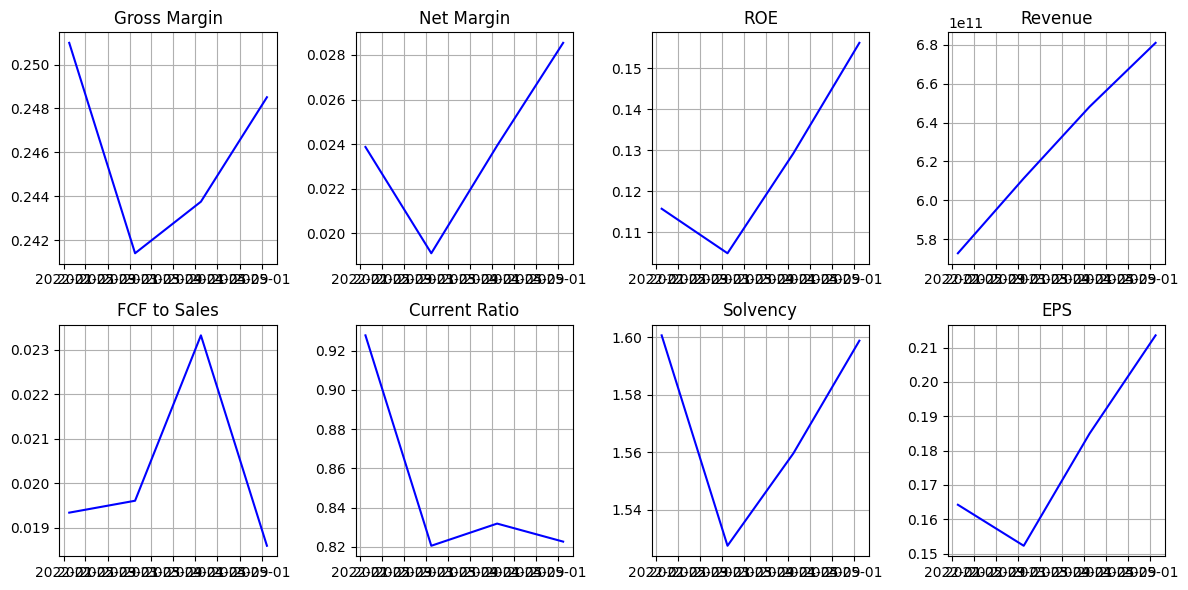

In [1069]:
for ticker in tickers_valuation[:5]:

    bs, ist, cf = get_financials(ticker)

    gross_margin = ist.loc['Gross Profit']/ist.loc['Total Revenue']

    net_margin = ist.loc['Net Income Common Stockholders']/ist.loc['Total Revenue']

    roe = ist.loc['Net Income Common Stockholders'] / bs.loc['Total Capitalization']

    revenue = ist.loc['Total Revenue']

    fcf_to_sales = cf.loc['Free Cash Flow'] / ist.loc['Total Revenue']

    current_ratio = bs.loc['Current Assets']/bs.loc['Current Liabilities']

    solvency = bs.loc['Total Assets']/bs.loc['Total Liabilities Net Minority Interest']

    eps = ist.loc['Net Income Common Stockholders'] / bs.loc['Common Stock Equity']

    df_multiplos = pd.DataFrame({
        'Gross Margin': gross_margin,
        'Net Margin': net_margin,
        'ROE': roe,
        'Revenue': revenue,
        'FCF to Sales': fcf_to_sales,
        'Current Ratio': current_ratio,
        'Solvency': solvency,
        'EPS': eps
    })

    df_multiplos.sort_index()

    print(f'Múltiplos de {ticker}')

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    axes = axes.ravel()  # Aplana la matriz de ejes para indexar con un solo número

    for i, column in enumerate(df_multiplos.columns):
        axes[i].plot(df_multiplos.index, df_multiplos.iloc[:, i], c = 'blue')
        axes[i].set_title(column)
        axes[i].grid()
    plt.tight_layout()
    plt.show()

In [1070]:
print(analizar_brkb())


Análisis de BRK-B
Precio Actual: $477.47
EPS (Trailing): $37.48
Price-to-Earnings (P/E): 12.74
ROA: 7.71%
ROE: 13.66%




In [1071]:
print(analizar_accion("AZO"))


Métricas de AZO:
Precio Actual: $3742.08
EPS (Trailing): $145.57
Price-to-Book (P/B): -15.75
Price-to-Earnings (P/E): 25.71

Evaluación:
P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett).
P/E: 25.71. Compara con el S&P 500 (~15–20) para contexto.


In [1072]:
print(analizar_accion("META"))


Métricas de META:
Precio Actual: $720.67
EPS (Trailing): $25.66
Price-to-Book (P/B): 9.83
Price-to-Earnings (P/E): 28.09

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 28.09. Compara con el S&P 500 (~15–20) para contexto.


In [1073]:
print(analizar_accion("NEM"))


Métricas de NEM:
Precio Actual: $57.61
EPS (Trailing): $4.21
Price-to-Book (P/B): 2.06
Price-to-Earnings (P/E): 13.68

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 13.68. Compara con el S&P 500 (~15–20) para contexto.


In [1074]:
print(analizar_accion("ED"))


Métricas de ED:
Precio Actual: $99.31
EPS (Trailing): $5.39
Price-to-Book (P/B): 1.50
Price-to-Earnings (P/E): 18.42

Evaluación:
P/B entre 1.2–1.6: Valuación razonable (rango histórico).
P/E: 18.42. Compara con el S&P 500 (~15–20) para contexto.


In [1075]:
print(analizar_accion("WMT"))


Métricas de WMT:
Precio Actual: $97.09
EPS (Trailing): $2.29
Price-to-Book (P/B): 9.25
Price-to-Earnings (P/E): 42.40

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 42.40. Compara con el S&P 500 (~15–20) para contexto.


---

## Tactical Asset Allocation

### Optimizar Pesos del Portafolio

In [1076]:
optimize_port = OptimizePortfolioWeights(returns=ret, risk_free=0.0445)

#### Optimización Minima Varianza

In [1077]:
w_minvar = optimize_port.opt_min_var()*0.5
dict_minvar = dict(zip(ret.columns, w_minvar))
dict_minvar

{'AZO': 0.0842111290183341,
 'BRK-B': 0.10899241420783348,
 'ED': 0.17154506075407527,
 'META': 0.047884636010783195,
 'NEM': 0.012607736086330345,
 'WMT': 0.07475902392264365}

#### Optimización Máximo de Sharpe

In [1078]:
w_maxsharpe = optimize_port.opt_max_sharpe()*0.5
dict_maxsharpe = dict(zip(ret.columns, w_maxsharpe))
dict_maxsharpe

{'AZO': 0.11257959456440034,
 'BRK-B': 0.0,
 'ED': 0.0337083628122114,
 'META': 0.09468429872278886,
 'NEM': 0.03564883109002532,
 'WMT': 0.22337891281057412}

#### Optimización Semi Varianza Target

In [1079]:
w_semivar = optimize_port.opt_min_semivar(rets_benchmark)*0.5
dict_semivar = dict(zip(ret.columns, w_semivar))
dict_semivar

{'AZO': 0.055979162482621504,
 'BRK-B': 0.1734572824946145,
 'ED': 0.07068432178151253,
 'META': 0.09053950797785114,
 'NEM': 0.013130253437857082,
 'WMT': 0.09620947182554324}

#### Optimización Máximo de Omega

In [1080]:
omega = optimize_port.opt_max_omega(rets_benchmark)*0.5
dict_omega = dict(zip(ret.columns, omega))
dict_omega

{'AZO': 5.908283029562911e-17,
 'BRK-B': 4.486663840595854e-15,
 'ED': 3.0692550565943365e-18,
 'META': 0.5000000000001601,
 'NEM': 5.464656044934287e-19,
 'WMT': 4.8062959196326655e-17}

##### Ponderaciones

In [1097]:
DataFrame_tactical = pd.DataFrame({
    'Mínima Varianza': dict_minvar,
    'Máximo Sharpe': dict_maxsharpe,
    'Mínimo Semivarianza': dict_semivar,
    'Max Omega': dict_omega,
})
DataFrame_tactical

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
AZO,0.084211,0.112580,0.055979,5.908283e-17
BRK-B,0.108992,0.000000,0.173457,4.486664e-15
ED,0.171545,0.033708,0.070684,3.069255e-18
META,0.047885,0.094684,0.090540,5.000000e-01
NEM,0.012608,0.035649,0.013130,5.464656e-19
WMT,0.074759,0.223379,0.096209,4.806296e-17


---

## Strategic Asset Allocation

 ### Obtención de Datos


In [1082]:
strategic_prices = yf.download(['SPY'], start='2024-01-01', end='2025-07-01', progress=False)['Close']

In [1083]:
returns_strategic = strategic_prices.pct_change().dropna()

### Optimizar portafolio Strategic

In [1084]:
optimize_strategic = OptimizePortfolioWeights(returns=returns_strategic, risk_free=0.0445)

#### Optimización Mínima Varianza

In [1085]:
w_min_var = optimize_strategic.opt_min_var()*0.5
dict_minvar_strategic = dict(zip(returns_strategic.columns, w_min_var))
dict_minvar_strategic

{'SPY': 0.5}

#### Optimización Máximo de Sharpe

In [1086]:
w_max_sharpe = optimize_strategic.opt_max_sharpe()*0.5
dict_maxsharpe_strategic = dict(zip(returns_strategic.columns, w_max_sharpe))
dict_maxsharpe_strategic

{'SPY': 0.5}

#### Optimización Semivarianza Target

In [1087]:
w_semivar_strategic = optimize_strategic.opt_min_semivar(rets_benchmark)*0.5
dict_semivar_strategic = dict(zip(returns_strategic.columns, w_semivar_strategic))
dict_semivar_strategic

{'SPY': 0.5}

#### Optimización Máximo Omega

In [1088]:
w_omega = optimize_strategic.opt_max_omega(rets_benchmark)*0.5
dict_omega_strategic = dict(zip(returns_strategic.columns, w_omega))
dict_omega_strategic

{'SPY': 0.5}

##### Ponderaciones

In [ ]:
DataFrame_strategic = pd.DataFrame({
    'Mínima Varianza': dict_minvar_strategic,
    'Máximo Sharpe': dict_maxsharpe_strategic,
    'Mínimo Semivarianza': dict_semivar_strategic,
    'Max Omega': dict_omega_strategic,
})
DataFrame_strategic*100

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega,Benchmark
SPY,50.0,50.0,50.0,50.0,100


---

### Portafolio

In [1090]:
combined_df = DataFrame_tactical.add(DataFrame_strategic, fill_value=0)
combined_df = combined_df.div(combined_df.sum())

Portafolio = combined_df
Portafolio



,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
AZO,0.084211,0.112580,0.055979,5.908283e-17
BRK-B,0.108992,0.000000,0.173457,4.486664e-15
ED,0.171545,0.033708,0.070684,3.069255e-18
META,0.047885,0.094684,0.090540,5.000000e-01
NEM,0.012608,0.035649,0.013130,5.464656e-19
SPY,0.500000,0.500000,0.500000,5.000000e-01
WMT,0.074759,0.223379,0.096209,4.806296e-17


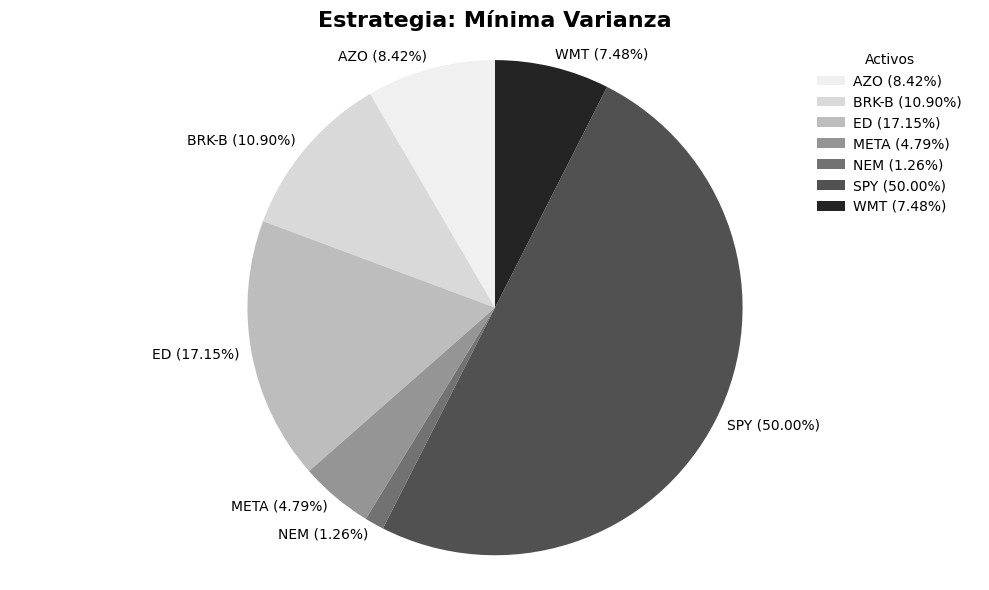

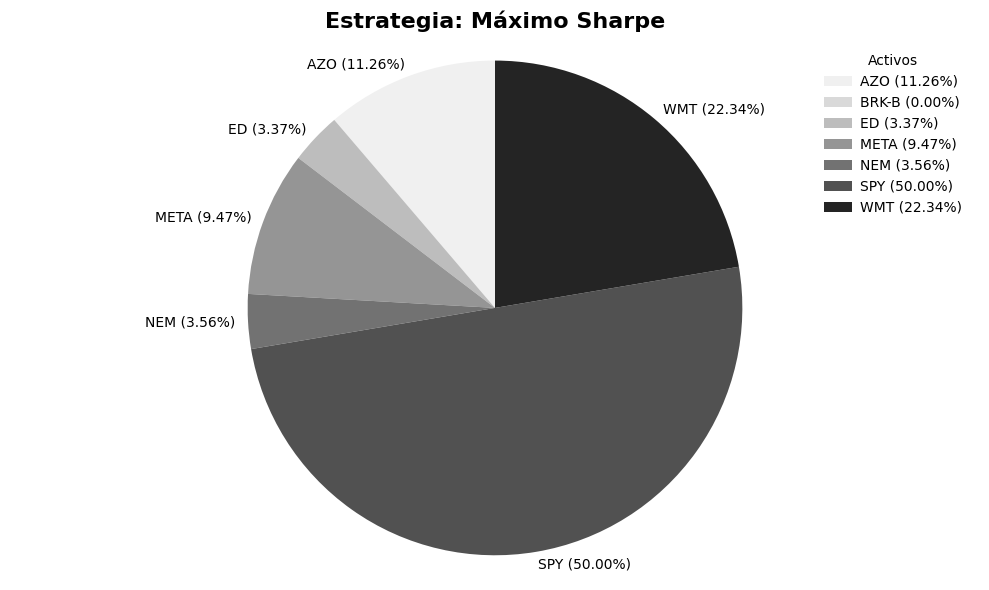

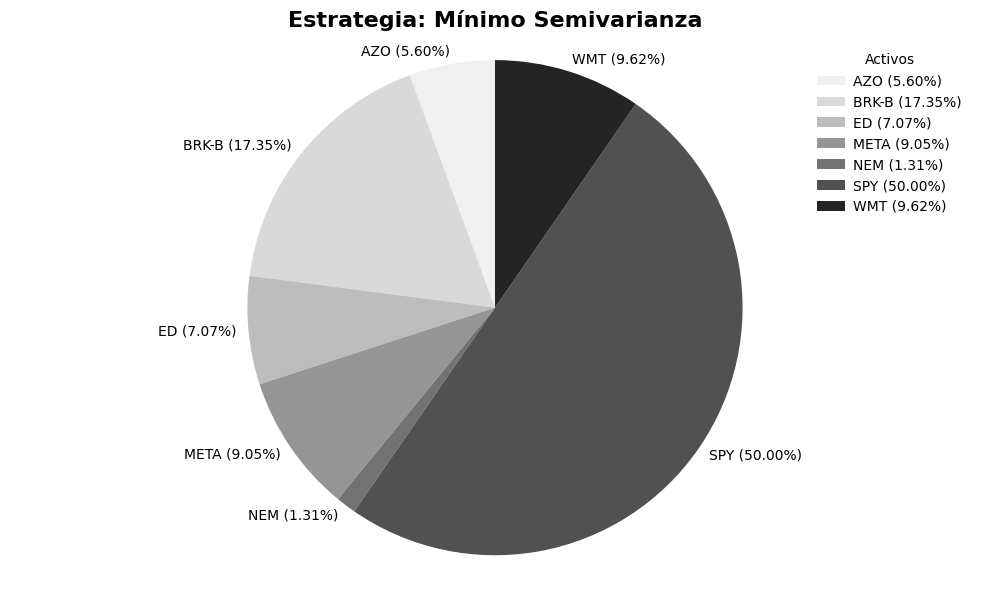

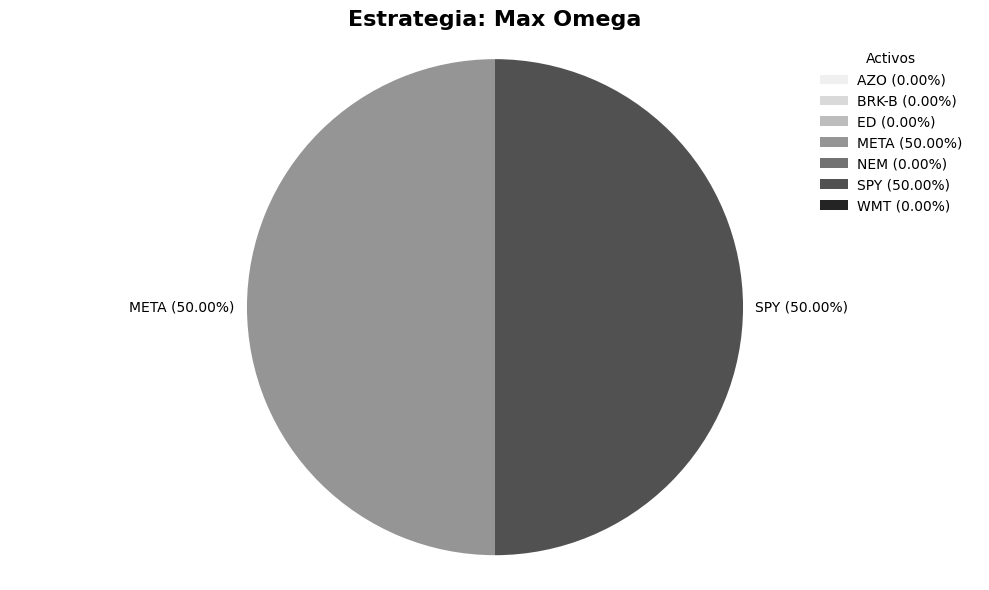

In [1091]:
plot_weights_pie(Portafolio, 'Mínima Varianza')
plot_weights_pie(Portafolio, 'Máximo Sharpe')
plot_weights_pie(Portafolio, 'Mínimo Semivarianza')
plot_weights_pie(Portafolio, 'Max Omega')

---

### Backtesting

In [1092]:
history = dynamic_backtesting(
    tickers,
    strategic_prices,
    benchmark,
    capital=1000000,
    rf=0.0445,
    months=4
).simulation()
history

,Mínima Varianza,Máximo Sharpe,Semi Varianza,Máximo Omega,Benchmark
Date,,,,,
2024-05-16,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.001165e+06
2024-05-17,1.004685e+06,1.004861e+06,1.004686e+06,9.993241e+05,1.002082e+06
2024-05-20,1.001861e+06,1.002350e+06,1.002300e+06,9.966493e+05,1.004589e+06
2024-05-21,1.004507e+06,1.004722e+06,1.003007e+06,9.933966e+05,1.001871e+06
2024-05-22,1.002046e+06,1.002084e+06,9.997473e+05,9.953339e+05,9.944762e+05
...,...,...,...,...,...
2025-06-20,1.212505e+06,1.219225e+06,1.228265e+06,1.347418e+06,1.137447e+06
2025-06-23,1.225877e+06,1.237028e+06,1.241307e+06,1.358130e+06,1.150097e+06
2025-06-24,1.231635e+06,1.246010e+06,1.247034e+06,1.373581e+06,1.150093e+06


## Visualización Backtesting

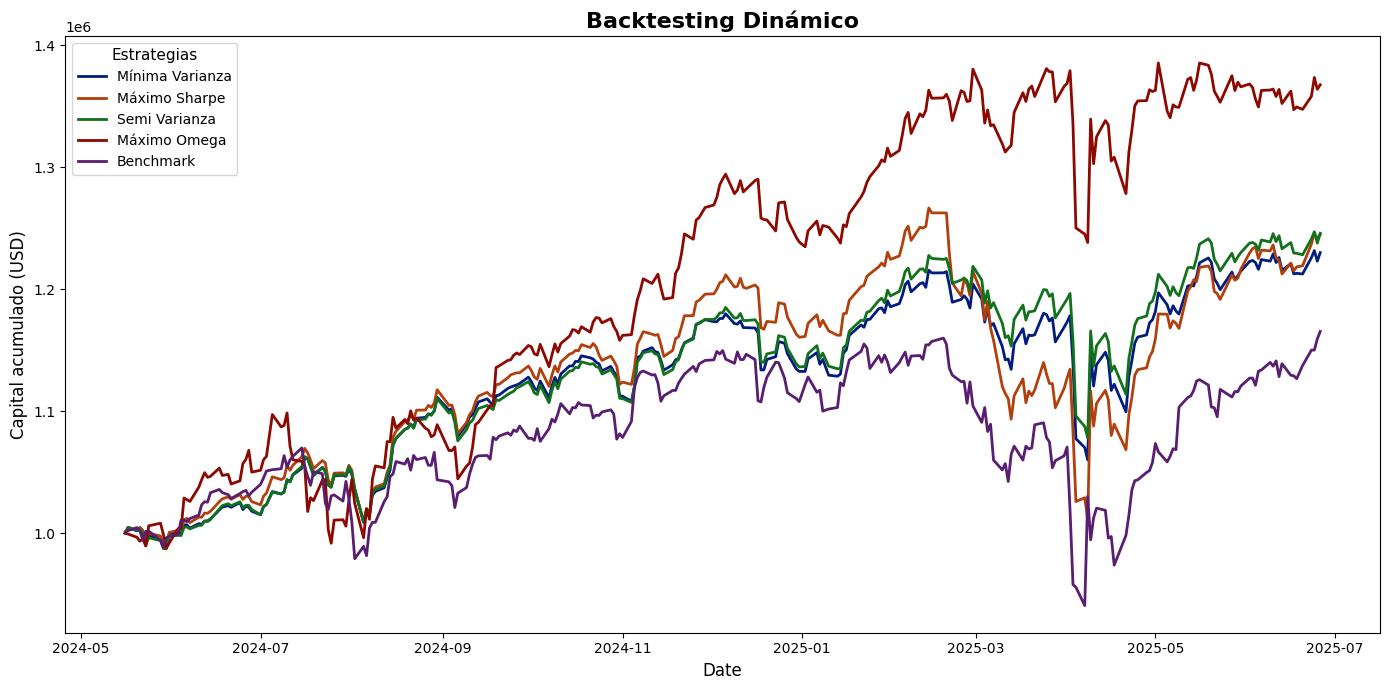

In [1093]:
plt.figure(figsize=(14, 7))

colors = sns.color_palette("dark", n_colors=len(history.columns))

for i, col in enumerate(history.columns):
    plt.plot(history.index, history[col], label=col, linewidth=2, color=colors[i])

plt.title('Backtesting Dinámico', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Capital acumulado (USD)', fontsize=12)

plt.legend(title="Estrategias", loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


### Métricas de Desempeño del Portafolio de Inversión


In [1094]:
metricas_anuales(history, rf=0.0445)

,Mínima Varianza,Máximo Sharpe,Semi Varianza,Máximo Omega,Benchmark
Rendimiento Promedio Anual,0.200315,0.215865,0.211704,0.303781,0.156177
Volatilidad Anual,0.155168,0.183770,0.153196,0.194685,0.190523
Ratio de Sharpe,1.004165,0.932499,1.091439,1.331796,0.586157
Downside Risk,0.091911,0.108312,0.091254,0.118012,0.117752
Upside Risk,0.104883,0.125216,0.102651,0.125105,0.122799
Omega,1.141146,1.156065,1.124896,1.060103,1.042862
Beta,-0.047821,-0.060156,-0.048112,-0.081076,1.000000
Alpha,0.161155,0.178083,0.172577,0.268335,0.000000
Ratio de Treynor,-3.258315,-2.848680,-3.475278,-3.197983,0.111677
Ratio de Sortino,1.695284,1.582141,1.832293,2.197065,0.948408


### Calculo de Pesos para Portafolio Real

---